In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob
import pickle
from scipy.linalg import hankel
from scipy.stats import norm, zscore
import statsmodels.api as sm
import matplotx
plt.style.use(matplotx.styles.aura['dark'])

In [2]:
def trial_xticks(ax, xlocs, yloc=-0.04):
    xlocs = np.array(xlocs)
    ax.set_xticks(xlocs)
    ax.set_xticklabels([])
    ax.tick_params("x", length=17, width=1, which="major")
    ax.set_xlabel("Time", labelpad=10)

    periods = ["S", "Cue", "Delay", "Arm", "Reward"]
    for i in range(5):
        xloc = xlocs[i] + (xlocs[i+1] - xlocs[i]) / 2
        ax.text(
            xloc,
            yloc,
            periods[i],
            fontsize=10,
            horizontalalignment="center",
            verticalalignment="top",
            transform=ax.get_xaxis_transform(),
            rotation=0,
        )
def nll(w, X, y):
    lam = np.exp(X @ w)
    # print(lam.shape)
    return -1 * y.T @ np.log(lam) + lam.sum() - 0.5 * w.T @ w
colors = ['tab:red', 'tab:blue']

In [3]:
with open('test_data_acc_ind_492_0607.pickle', 'rb') as handle:
    data = pickle.load(handle)
print(data.keys())
n_neurons = len(data['spikes'])
print(f'n_neurons: {n_neurons}')


dict_keys(['nCues_RminusL', 'currMaze', 'laserON', 'trialStart', 'trialEnd', 'keyFrames', 'time', 'cueOnset_L', 'cueOnset_R', 'choice', 'trialType', 'pos', 'spikes', 'timeSqueezedFR'])
n_neurons: 324


In [112]:
time_squeezedFR = np.array(data['timeSqueezedFR'])
mean_fr = time_squeezedFR.mean(axis=(1, 2))
std_fr = time_squeezedFR.std(axis=2).mean(axis=1)
sorted_neurons = np.argsort(mean_fr*std_fr)[::-1]
sorted_neurons[:20]
# time_squeezedFR.shape

array([129, 232,  36, 116, 186, 212, 226,  86, 131,  41,  33, 117, 121,
       120,  70, 237, 149, 271, 123, 216])

In [152]:
# constructing design matrix with all trials

neuron = 36
trial_indices = np.nonzero((data["currMaze"] > 7)*(data['laserON'] == 0))[0]
print(f'number of trials: {trial_indices.size}')
X = []
y = []
filt_len = 30
sp_filt_len = 30
bin_size = 0.35
trial_id = []
bin_positions = []
bin_centers_all = []

for trial_idx in trial_indices:
    keyframes = data["keyFrames"][trial_idx]
    keyframe_times = data["time"][trial_idx][keyframes.astype(int)].tolist()
    trial_start = data["trialStart"][trial_idx]
    # trial_end = data["trialEnd"][trial_idx]
    # lcue_times = data["cueOnset_L"][trial_idx] 
    # rcue_times = data["cueOnset_R"][trial_idx]
    # trial_start = keyframe_times[0] + data["trialStart"][trial_idx]
    trial_end = keyframe_times[2] + trial_start
    lcue_times = data["cueOnset_L"][trial_idx] - keyframe_times[0] # remove keyframe subtraction if using all phases of trial
    rcue_times = data["cueOnset_R"][trial_idx] - keyframe_times[0]

    trial_length = trial_end - trial_start
    spikes = data["spikes"][neuron]
    spikes = spikes[(spikes > trial_start) * (spikes < trial_end)]
    
    

    bins = np.arange(0, trial_length, bin_size)
    bin_centers = np.convolve(bins, [0.5, 0.5], mode="valid")
    bin_centers_all.append(bin_centers)

    time = data['time'][trial_idx][:, np.newaxis]
    pos = data['pos'][trial_idx][:, 1]
    bin_centers = bin_centers.reshape(-1, 1)
    dist = (time[:pos.size].T - bin_centers)
    bin_time_index = np.argmin(np.abs(dist), axis=1)
    binned_pos = pos[bin_time_index]
    bin_positions.append(binned_pos)
    means = np.linspace(0, 275, 10)
    pos_gauss = []
    for mu in means:
        dist = norm(mu, 10)
        pos_gauss.append(dist.pdf(binned_pos))
    pos_gauss = np.array(pos_gauss)

    binned_stimr, _ = np.histogram(rcue_times, bins)
    binned_stiml, _ = np.histogram(lcue_times, bins)
    binned_spikes, _ = np.histogram(spikes - trial_start, bins)
    binned_ev = np.cumsum(binned_stimr) - np.cumsum(binned_stiml)

    padded_stimr = np.pad(binned_stimr, (filt_len - 1, 0), constant_values=(0, 0))
    X_sr = hankel(padded_stimr[: -filt_len + 1], padded_stimr[-filt_len:])
    padded_stiml = np.pad(binned_stiml, (filt_len - 1, 0), constant_values=(0, 0))
    X_sl = hankel(padded_stiml[: -filt_len + 1], padded_stiml[-filt_len:])
    padded_ev = np.pad(binned_ev, (filt_len - 1, 0), constant_values=(0, 0))
    X_ev = hankel(padded_ev[: -filt_len + 1], padded_ev[-filt_len:])

    padded_spikes = np.pad(binned_spikes[:-1], (sp_filt_len, 0), constant_values=(0, 0))
    X_sp = hankel(padded_spikes[: -sp_filt_len + 1], padded_spikes[-sp_filt_len:])

    trial_type = data['trialType'][trial_idx]
    X_pos = np.hstack((trial_type*pos_gauss.T, (1-trial_type)*pos_gauss.T))
    
    # need to add second pos matrix for choice or evidence
    X.append(np.hstack((X_sr, X_sl, X_pos, np.ones((X_sp.shape[0], 1)))))
    # X.append(np.hstack((X_sr, X_sl, np.ones((X_sp.shape[0], 1)))))

    y.append(binned_spikes[:, np.newaxis])

    trial_id.append(trial_idx * np.ones(X_sr.shape[0]))

    
# zscore????
X = np.vstack(X)
X[:, :60] = zscore(X[:, :60], axis=None)
X[:, 60:-1] = zscore(X[:, 60:-1], axis=0)
y = np.vstack(y)
trial_id = np.hstack(trial_id)
#, 
print(0, keyframe_times, trial_end-trial_start)
print(X.shape)
print(rcue_times)

number of trials: 210
0 [0.5845199823379517, 9.808429718017578, 125.71129608154297, 126.09971618652344] 125.71129608154297
(4982, 81)
[5.1630216 6.16279   6.889923  8.341651  8.658106 ]


<Axes: >

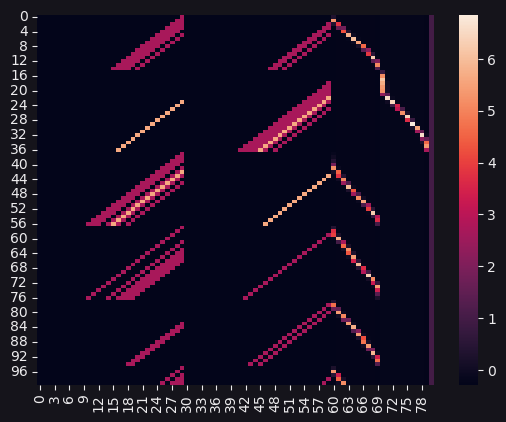

In [153]:
sns.heatmap(X[:100, :])

LL: 224082.3221647148
3.121769491804919


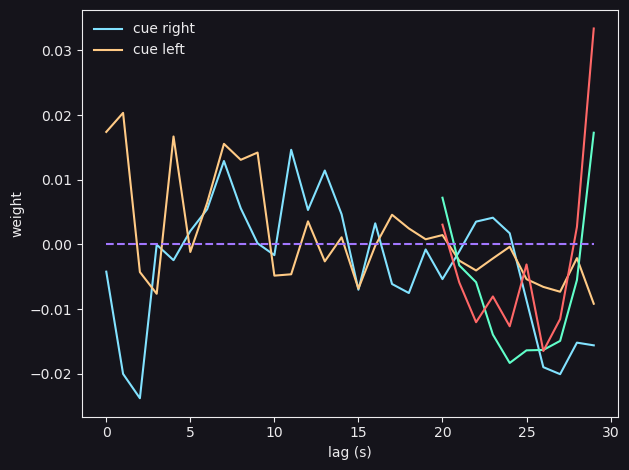

In [155]:

weights = np.zeros(y.shape[0]) * 0.0001
weights[:1000] = 1

glm = sm.GLM(endog=y, exog=X, family=sm.families.Poisson())#, freq_weights=weights)

# res = glm.fit(max_iter=1000, tol=1e-6, tol_criterion="params")
alpha = 0.5 * np.ones(X.shape[1])
alpha[-1] = 0.001
res = glm.fit_regularized(alpha=alpha, L1_wt=0.0, maxiter=1000, cnvrg_tol=1e-6)
w = res.params
rate = np.exp(X@w)

LL = y.T @ np.log(rate) - rate.sum()
print(f"LL: {LL[0]}")

fig, ax = plt.subplots()
ax.plot(w[:(2*filt_len)].reshape(-1, filt_len).T, label=["cue right", "cue left"])
# ax.plot(np.arange(filt_len)[-sp_filt_len:], w[(2*filt_len):-1], label='spikes')
ax.plot(np.arange(20, 30), w[(2*filt_len):-1].reshape(2, -1).T)
# ax.plot(w[:-1].reshape(-1, filt_len).T, label=["cue right", "cue left"])

ax.plot(np.arange(filt_len), np.zeros(filt_len), "--")
ax.legend()
xlabels = np.round(
    -1 * np.arange(bin_size, filt_len * bin_size + bin_size, bin_size)[::-3], 1
)
# ax.set_xticks(np.arange(filt_len)[::2], xlabels)
ax.set_xlabel("lag (s)")
ax.set_ylabel("weight")
plt.tight_layout()


print(w[-1])

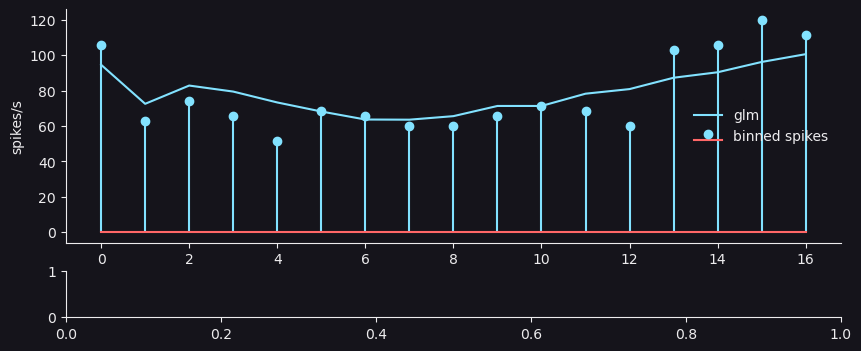

In [148]:
fig, axs = plt.subplots(2, 1, figsize=(10, 4), gridspec_kw={"height_ratios": [5, 1]})

sort_idx = np.argsort(
    data["nCues_RminusL"]
)  # ordered index of (lots of left cues) -> (lots of right cues)
sort_idx = sort_idx[(data['currMaze'][sort_idx] > 7)* (data['laserON'][sort_idx] ==0)]
plot_trial = sort_idx[25]
X_plot = X[trial_id == plot_trial]
# y_pred = np.exp(X_plot @ theta_init[:, neuron])
y_pred = np.exp(X_plot @ w.T) / 0.35

# y_pred = np.exp(X_plot @ theta_post[:, :, neuron].T)

y_plot = y[trial_id == plot_trial]/0.35
axs[0].stem(y_plot, label="binned spikes")
axs[0].plot(y_pred, label='glm')
# trial_xticks(axs[0], xlocs=[0] + keyframe_times + [trial_length], yloc=-0.1)
axs[0].set_ylabel("spikes/s")
axs[0].legend()


# axs[1].plot(bin_centers, binned_stimr, color=colors[0], label="right towers")
# axs[1].plot(bin_centers, binned_stiml, color=colors[1], label="left towers")
# trial_xticks(axs[1], xlocs=[0] + keyframe_times + [trial_length], yloc=-0.1)
# axs[1].set_ylabel("# of towers")
# axs[1].set_title("Binned Stimulus")
# axs[1].legend()
# plt.tight_layout()
sns.despine()


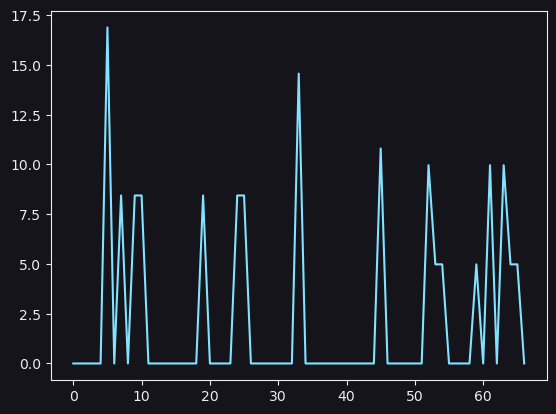

In [77]:
plt.plot(data['timeSqueezedFR'][neuron][plot_trial])

In [20]:
# indices to exclude due to reversal of position
count = 0
turn_idx = []
for i, pos in enumerate(bin_positions):
    grad = np.diff(pos)
    if np.any(grad<-5):
        count+=1
        turn_idx.append(i)
print(count, turn_idx)

23 [238, 246, 251, 252, 253, 254, 255, 260, 262, 264, 265, 266, 269, 274, 277, 278, 280, 281, 282, 283, 287, 288, 289]
